In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


sns.set(style='whitegrid', font_scale=1.3)
%matplotlib inline

## Small intro
In this notebook I try to solve binary classification problem. I want to create model with best params to predict wheteher job ad is real or fake. 

To achieve good result I preprocess initial text features and add new ones.

Additionally, I want to find out most important features for my model.

# Exploratory analysis

In [152]:
data = pd.read_csv('fake_job_postings.csv', index_col='job_id')
data.shape

(17880, 17)

In [153]:
data.head(4)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

##### Count NaN per column in %

In [155]:
(data.isna().sum() / data.shape[0]).sort_values(ascending=False)

salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403244
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150727
location               0.019351
description            0.000056
fraudulent             0.000000
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
title                  0.000000
dtype: float64

In [156]:
data.nunique() 

title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [157]:
print('fraudulent == 1 count {} or {:.2f}% from all data'.format(
    data['fraudulent'].sum(), 
    data['fraudulent'].sum() / data.shape[0] * 100)
     )

positive = data[data['fraudulent'] == 1].shape[0]
negative = data[data['fraudulent'] == 0].shape[0]

class_weights = {0: 1, 1: negative / positive}

fraudulent == 1 count 866 or 4.84% from all data


In [158]:
raw_data = data.copy()

## Feature mining

### Location
Extract country, state and city info from location columns

In [159]:
data['location'] = data['location'].fillna(',,')
data['location'] = data['location'].apply(lambda x: x if len(x.split(',')) >= 3 else x + ',,')

# Add region features
data['country'] = data['location'].apply(lambda x: x.split(',')[0])
data['state'] = data['location'].apply(lambda x: x.split(',')[1])
data['city'] = data['location'].apply(lambda x: x.split(',')[2])

data.drop(columns=['location'], inplace=True)

### Text data

Extract word count and length fo the whole text description for each text column.

In [160]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
num_col = []
name_col = []

# Добавим признаки длины текста
for col in text_columns:
    data['len_' + col] = data[col].fillna('').apply(lambda x: len(x))
    
    num_col.append('len_' + col)
    name_col.append(col + ' length')

data.drop(columns=text_columns, inplace=True)

## Visualization

Let\`s explore our data!

In [161]:
positive = data[data['fraudulent'] == 1]
negative = data[data['fraudulent'] == 0]

fraud_c = '#f7714f'
real_c = '#4fe9f7'

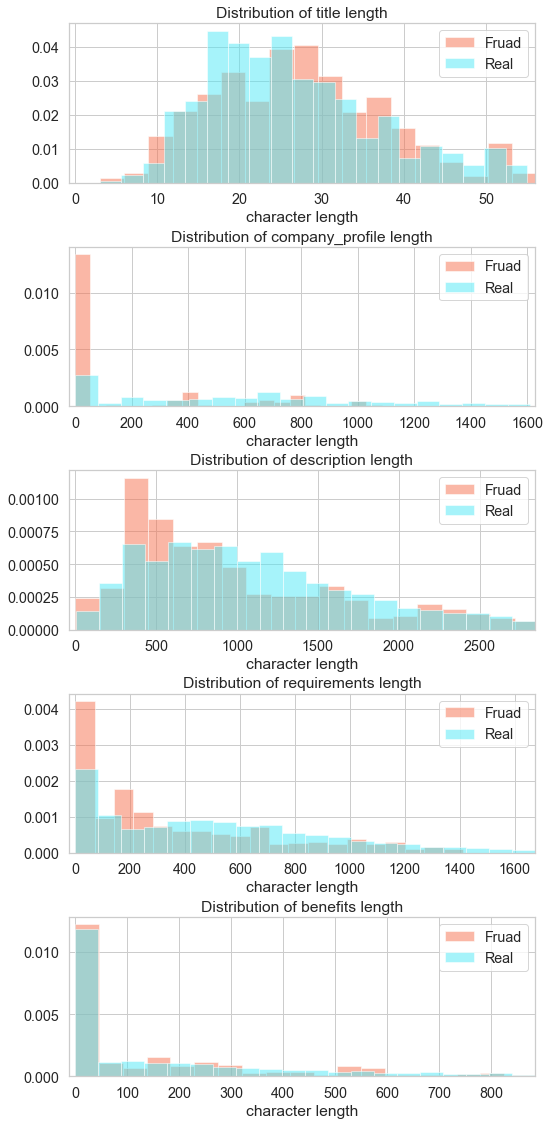

In [167]:
fig, axes = plt.subplots(5, figsize=(8, 16))
fig.tight_layout(pad=3.5)
legend = {'len' : 'character length'}

for ax, col, name in zip(axes.flat, num_col, name_col):
    ax.hist(positive[positive[col] < positive[col].quantile(0.95)][col], bins=20, alpha=0.5, density=True, color=fraud_c)
    ax.hist(negative[negative[col] < negative[col].quantile(0.95)][col], bins=20, alpha=0.5, density=True, color=real_c)
    
    ax.set_title('Distribution of {}'.format(name))
    ax.legend(['Fruad', 'Real'])
    
    ax.set_xlim([- negative[col].quantile(0.95) / 70, negative[col].quantile(0.95)])
    ax.set_xlabel(legend[col[:3]])

#### There are 2 columns with a big difference: requirements and company_profile
I suppose these features will have a big impact on fraudulent prediction model

### Prepare cotegorical columns
Use integer labels. Fill NaN with zero value.

In [168]:
categorical_col = [
    'department', 'salary_range', 'employment_type', 
    'required_experience', 'required_education', 
    'industry', 'function',
    'country', 'state', 'city'
]

for cat in categorical_col:
    val = set(data[cat].values)
    category_mapping = dict(zip(val, range(len(val))))
    
    data[cat] = data[cat].fillna(np.nan).apply(lambda x: category_mapping[x])

### Pearson Correlation with target value

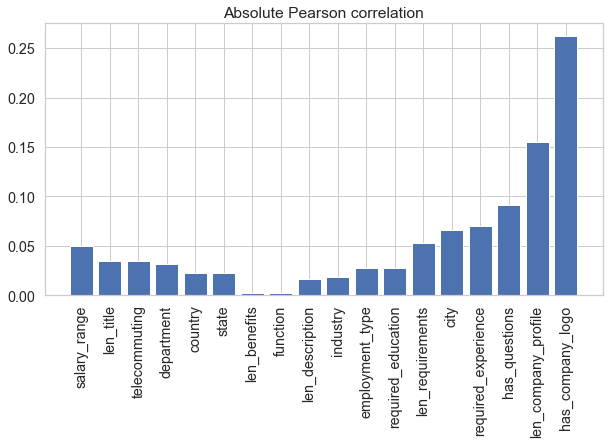

In [169]:
plt.figure(figsize=(10,5))

cor = data.corr()
cor = abs(cor['fraudulent'].sort_values(ascending=False).iloc[1:])

plt.bar(np.arange(cor.shape[0]), cor)
plt.title("Absolute Pearson correlation")
plt.xticks(np.arange(cor.shape[0]),cor.index, rotation=90)
plt.show()

#### There are seme features whiich has linear dependency with target value. For example has_company_logo, has_questions and company_profile features.

#### Lets calculate more precisely feature importance.

In [197]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def train_and_evaluate_model(
    classifier, x_train_, y_train_, x_test_, y_test_):
    model = classifier
    
    model.fit(x_train_, y_train_)
    predicted = model.predict_proba(x_test_)[:, 1]
    
    auc_score = calculate_auc_pr(y_test_, predicted)
    
    return predicted, model, auc_score

def calculate_auc_pr(test, predicted_proba):
    precision, recall, _ = precision_recall_curve(test, predicted_proba)
    return auc(recall, precision)

In [296]:
target = data['fraudulent']
features = data.drop(columns=['fraudulent'])
importance = {}

x_train, x_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=0
    ) # Split the data

for feature in data.drop(columns=['fraudulent']).columns:
    x_train_current = x_train[feature].values[:, None]
    x_test_current = x_test[feature].values[:, None]
    
    _, _, score = train_and_evaluate_model(
        CatBoostClassifier(
            num_trees = 10,
            verbose=0, 
            class_weights=list(class_weights.values())
        ),
        x_train_current,
        y_train,
        x_test_current,
        y_test
    )
    
    importance[feature] = score

#### Score per model trained only with one feature

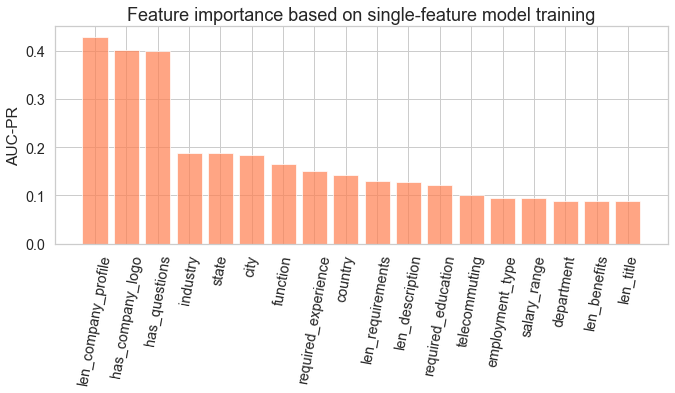

In [352]:
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(11, 4))

plt.bar(np.arange(len(importance)), importance.values(), color='coral', alpha=0.7)
plt.xticks(np.arange(len(importance)), importance.keys(), rotation=80)
plt.ylabel('AUC-PR')
plt.title('Feature importance based on single-feature model training', fontsize=18)
plt.savefig('img/single_feature.jpg',  bbox_inches = 'tight')
plt.show()

There is feature len_company_profile which refers to the text columns. It represents only number of  characters in this columns. Lets try to add tf-idf representation for this column. And compare results with and without tf-idf on company_profile.

In [272]:
from sklearn.feature_extraction.text import TfidfVectorizer

docs = raw_data['company_profile'].fillna('').apply(lambda x: x.lower())

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

In [286]:
X = vectorizer.fit_transform(docs)
X = pd.DataFrame(X.toarray())
X.index = data.index

In [293]:
tf_idf_data = pd.concat([data, X], axis=1)
tf_idf_data.shape

(17880, 2019)

# Predict the fraudulent

### As mentioned before, the dataset has unbalanced classes.

In [202]:
scaler = StandardScaler()
scaled = scaler.fit_transform(features)

assert scaled.mean() < 1e-6 and (scaled.std() - 1) < 1e-6

sc_x_train, sc_x_test, sc_y_train, sc_y_test = train_test_split(features, target, test_size=0.3, random_state=0)

#### LogisticRegression (baseline)

In [204]:
predicted, LogReg, score = train_and_evaluate_model(
    LogisticRegression(class_weight='balanced',  solver='liblinear'),
    x_train,
    y_train,
    x_test,
    y_test
)

print("AUC-PR for {}: {:.4f}".format(LogReg, score))

AUC-PR for LogisticRegression(class_weight='balanced', solver='liblinear'): 0.1873


Got only 0.18 AUC-PR

#### Gradient boosting

In [297]:
# Catboost
catboost_pred, catboost_model, score = train_and_evaluate_model(
    CatBoostClassifier(
        num_trees = 100,
        verbose=0, 
        class_weights=list(class_weights.values())
    ),
    x_train,
    y_train,
    x_test,
    y_test
)

print("AUC-PR for {}: {:.4f}".format('CatBoostClassifier', score))

AUC-PR for CatBoostClassifier: 0.7738


In [305]:
%%time
# CatBoost on tf-idf
features = tf_idf_data.drop(columns=['fraudulent'])

x_train, x_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=0
    ) # Split the data

tf_idf_pred, tf_idf_model, score = train_and_evaluate_model(
    CatBoostClassifier(
        num_trees=100,
        verbose=0, 
        class_weights=list(class_weights.values()),
    ),
    x_train,
    y_train,
    x_test,
    y_test
)

print("AUC-PR for {}: {:.4f}".format('CatBoostClassifier', score))

AUC-PR for CatBoostClassifier: 0.8585
Wall time: 5.77 s


#### What a great performace!
Get extra 0.08 to AUC-PR score with tf-idf encoding.

### Try GridSearch to get best params

In [307]:
%%time
params = {
    'num_trees': [75, 100, 150], 
    'depth': [4, 6], 
    'verbose': [0],
    'class_weights': [list(class_weights.values())],
}

grid_search = GridSearchCV(CatBoostClassifier(), params)
grid_search.fit(x_train, y_train)

Wall time: 2min 29s


GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000018C1AF3A160>,
             param_grid={'class_weights': [[1, 19.64665127020785]],
                         'depth': [4, 6], 'num_trees': [75, 100, 150],
                         'verbose': [0]})

In [316]:
best_score = calculate_auc_pr(
      y_test,
    grid_search.best_estimator_.predict_proba(x_test)[:,1]
)

print("AUC-PR for {}: {:.4f}".format('CatBoostClassifier', best_score))

AUC-PR for CatBoostClassifier: 0.8768


Great! 0.02 to the test score.

#### Let's save the best model and processed data

In [327]:
grid_search.best_estimator_.save_model('model.cbm')

In [329]:
catboost_model.save_model('small_model.cbm')

In [322]:
tf_idf_data.to_csv('processed.csv')